In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from utils import *
from filters import LKF_CA
from simulation import *
from scenarios import get_scenario

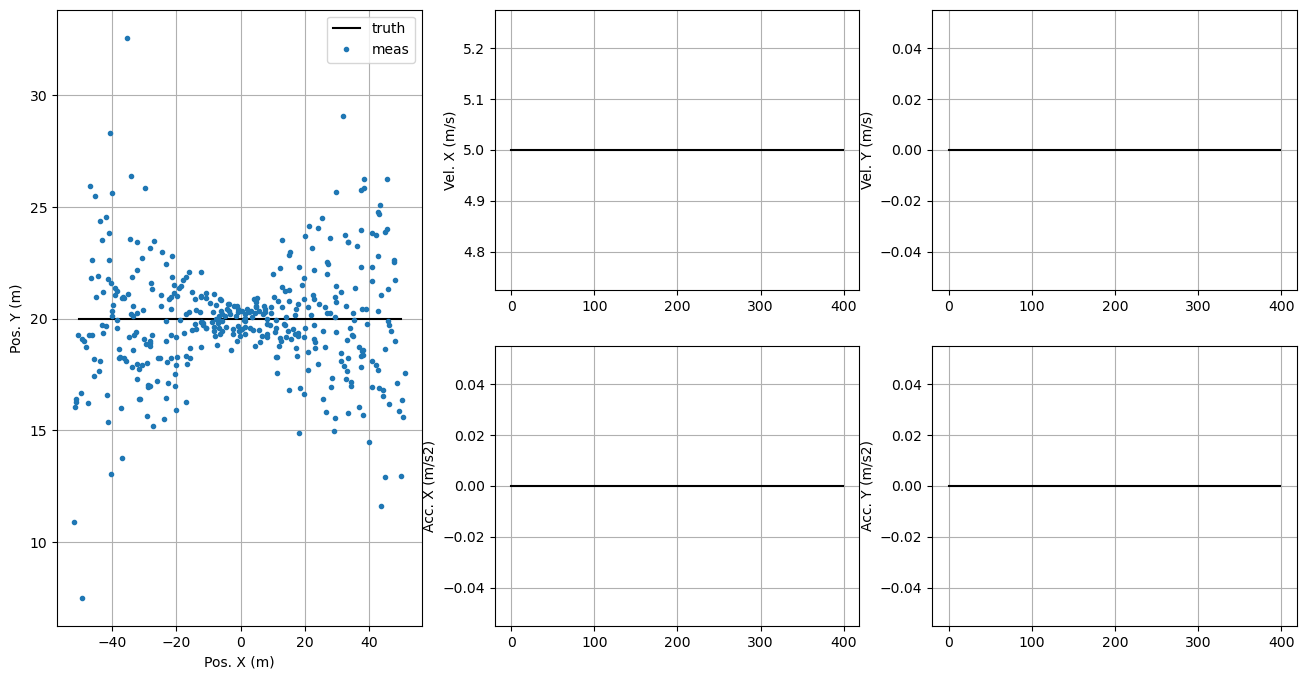

In [3]:
T = 0.05  # time between cycles
dim_state = 6 # dimension of state
dim_meas = 3 # dimension of measurements
std_r, std_phi, std_doppler = 0.5, np.radians(5), 0.1

sc_id = '1'
sc = get_scenario(sc_id, T)
n_frames = int(sc['n_frames'])
frame_vec = np.arange(n_frames)  

# truth motion
F_sim = LKF_CA.get_state_transition(T)
sim_state = simulate_motion(F_sim, dim_state, n_frames, sc['x_init'], sc.get('ax_frames'), sc.get('ay_frames'))
meas = simulate_measurements(sim_state, std_r, std_phi, std_doppler)

# scenario viewer
plot_options = [
    {'grid_pos': (0, 1), 'index': IVX, 'ylabel': 'Vel. X (m/s)'},
    {'grid_pos': (0, 2), 'index': IVY, 'ylabel': 'Vel. Y (m/s)'},
    {'grid_pos': (1, 1), 'index': IAX, 'ylabel': 'Acc. X (m/s2)'},
    {'grid_pos': (1, 2), 'index': IAY, 'ylabel': 'Acc. Y (m/s2)'},
]
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 3)
# X-Y plot
ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(sim_state[IX, :], sim_state[IY, :], 'k-', label='truth')
ax1.plot(meas[IMX, :], meas[IMY], '.', label='meas')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Pos. X (m)')
ax1.set_ylabel('Pos. Y (m)')
for p in plot_options:
    ax = fig.add_subplot(gs[*p['grid_pos']])
    ax.plot(frame_vec, sim_state[p['index'], :], 'k-', label='truth')
    ax.set_ylabel(p['ylabel'])
    ax.grid()